# 0. Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import random

plt.rcParams["figure.figsize"] = (30, 4)
radius = 30

1. Initially, I tried uniform distribution and it doesn't look so right--the pattern is too obvious...
2. But I am also concerned that drawing random noise from a normal distribution can be too easy for models--many models are built based on the assumptions that noise is normally distributed which is, of course, not always the case...
3. Guess we have to make our hands dirty this time...But yes, at the end, we may still get something close to a normal distribution given the Central Limit Theorem...

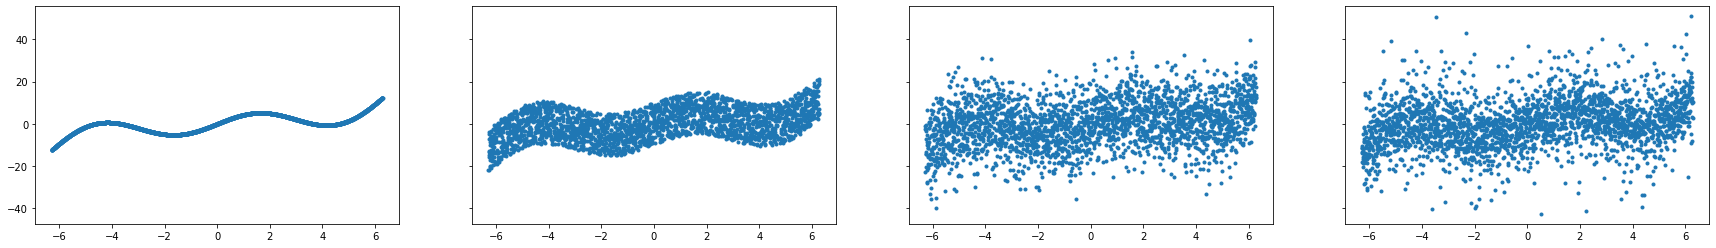

In [2]:
x = np.arange(-2 * np.pi, 2 * np.pi, 0.005)
np.random.shuffle(x)
y_true = 5 * np.sin(x) + 0.05 * x ** 3

fig, axes = plt.subplots(1, 4, sharey='row')

axes[0].scatter(x, y_true, marker='.')

y = y_true + np.random.uniform(low=-10, high=10, size=len(x))
axes[1].scatter(x, y, marker='.')

y = y_true + np.random.normal(loc=0, scale=10, size=len(x))
axes[2].scatter(x, y, marker='.')

y = y_true.copy()
for i in range(len(y)):
    rand = abs(np.random.poisson(lam=10))
    y[i] += np.random.uniform(low=-rand, high=rand)
    if random.randint(0, 128) % 2 == 0:
        y[i] += np.random.normal(loc=np.random.uniform(low=-10, high=10), scale=np.random.poisson(lam=10))
axes[3].scatter(x, y, marker='.')

plt.show()
plt.rcParams["figure.figsize"] = (30, 10)

In [3]:
_, _, y_train_true, y_test_true = train_test_split(x, y_true, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

# 1. Traditional machine learning model--from high bias to low bias
With some basic parameter tunning, the primitive decision tree regressor performs actually okay.

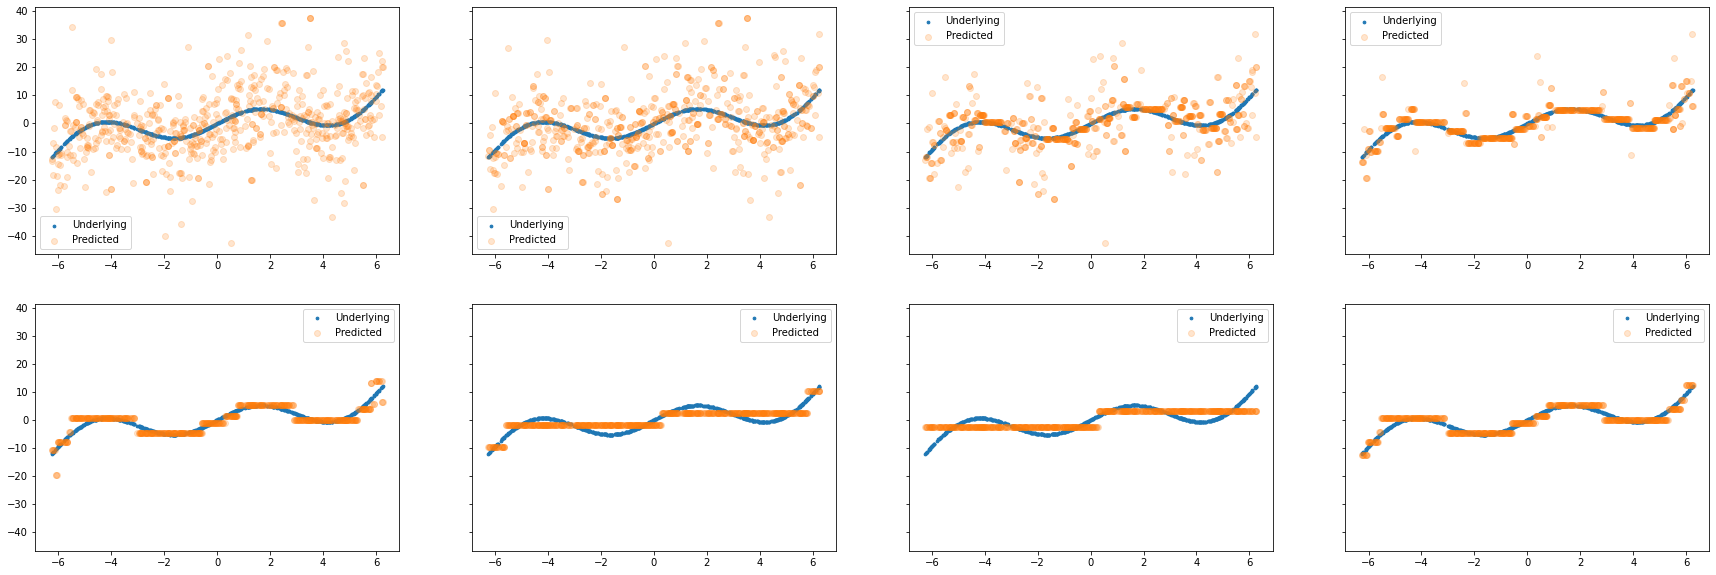

In [4]:
from sklearn.tree import DecisionTreeRegressor as dtr

fig, axes = plt.subplots(2, 4, sharey='all')
# First combination is default values
max_depth = [None, 32, 16, 8, 4, 2, 1]
min_samples_split = [2, 4, 8, 16, 32, 64, 128]

ax_len = axes.shape[0] * axes.shape[1]
for i in range(ax_len-1):
    regr = dtr(random_state=1, max_depth=max_depth[i], min_samples_split=min_samples_split[i]).fit(x_train.reshape(-1, 1), y_train)
    y_pred = regr.predict(x_test.reshape(-1, 1))
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].legend()

parameters = {'max_depth':[32, 16, 8, 4, 2, 1], 'min_samples_split':[2, 4, 8, 16, 32, 64], 'max_features': ['auto', 'sqrt', 'log2']}
regr = GridSearchCV(estimator=dtr(), param_grid=parameters, n_jobs=16)
regr.fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
axes[axes.shape[0]-1][axes.shape[1]-1].legend()
plt.show()

But how about Random Forest?

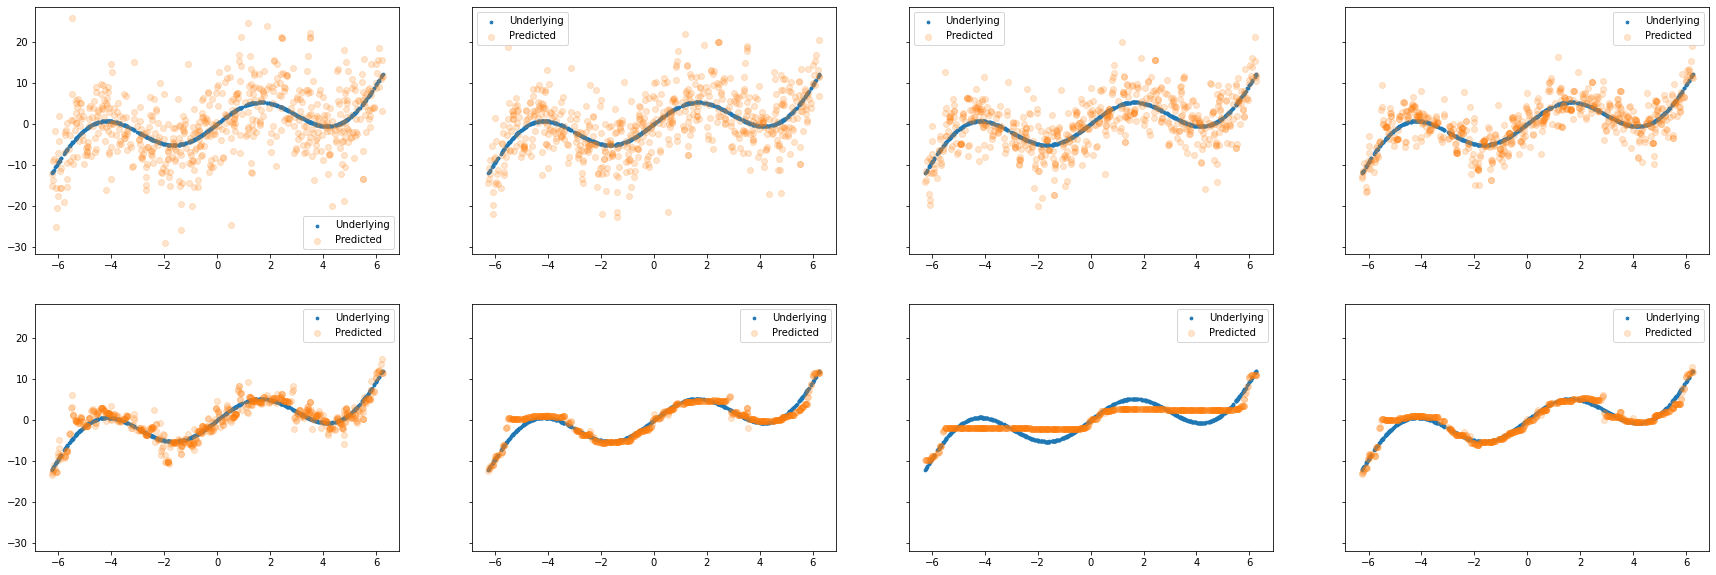

In [5]:
from sklearn.ensemble import RandomForestRegressor as rfr

fig, axes = plt.subplots(2, 4, sharey='all')
# First combination is default values
max_depth = [None, 64, 32, 16, 8, 4, 2]
min_samples_split = [2, 4, 8, 16, 32, 64, 128]

ax_len = axes.shape[0] * axes.shape[1]
for i in range(ax_len-1):
    regr = rfr(random_state=1, max_depth=max_depth[i], min_samples_split=min_samples_split[i]).fit(x_train.reshape(-1, 1), y_train)
    y_pred = regr.predict(x_test.reshape(-1, 1))
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].legend()
    
parameters = {
    'max_depth':[None, 64, 32, 16, 8, 6, 4, 3, 2], 
    'min_samples_split':[2, 4, 8, 16, 32, 48, 64, 80, 96, 128], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False],
    'n_estimators': [50, 100, 200, 400, 800]}
regr = GridSearchCV(estimator=rfr(), param_grid=parameters, n_jobs=32)
regr.fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
axes[axes.shape[0]-1][axes.shape[1]-1].legend()

plt.show()

It does have better performance compared with Decision Tree. All we tried until now are tree-based models, how about SVM?

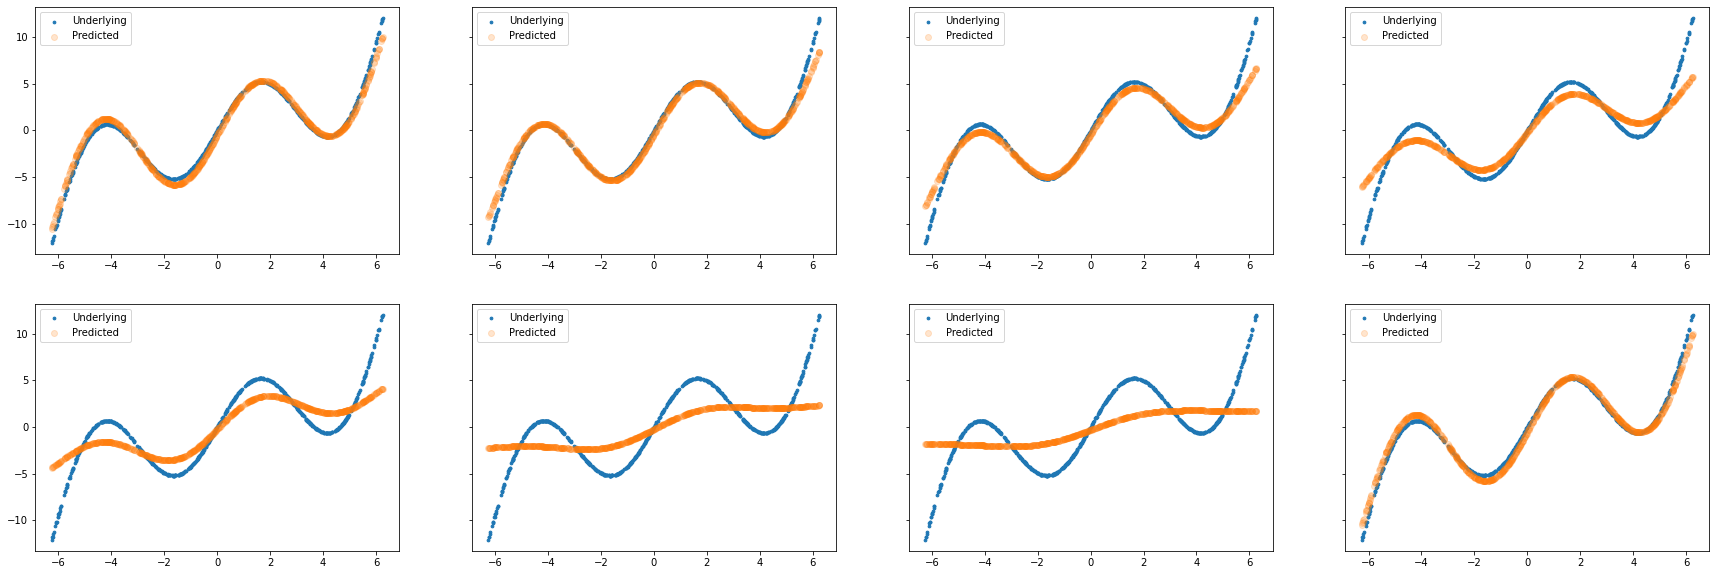

In [6]:
from sklearn.svm import SVR as svr

fig, axes = plt.subplots(2, 4, sharey='all')
# FOURTH element is the default value
C = [8, 4, 2, 1, 0.5, 0.1, 0.05]

ax_len = axes.shape[0] * axes.shape[1]
for i in range(ax_len-1):
    regr = svr(C=C[i]).fit(x_train.reshape(-1, 1), y_train)
    y_pred = regr.predict(x_test.reshape(-1, 1))
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].legend()
    
    
parameters = {
    'C':[8, 4, 2, 1, 0.5, 0.1, 0.05],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]    
}
regr = GridSearchCV(estimator=svr(), param_grid=parameters, n_jobs=32)
regr.fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
axes[axes.shape[0]-1][axes.shape[1]-1].legend()
plt.show()

Looks good, let's try nearest neighbors

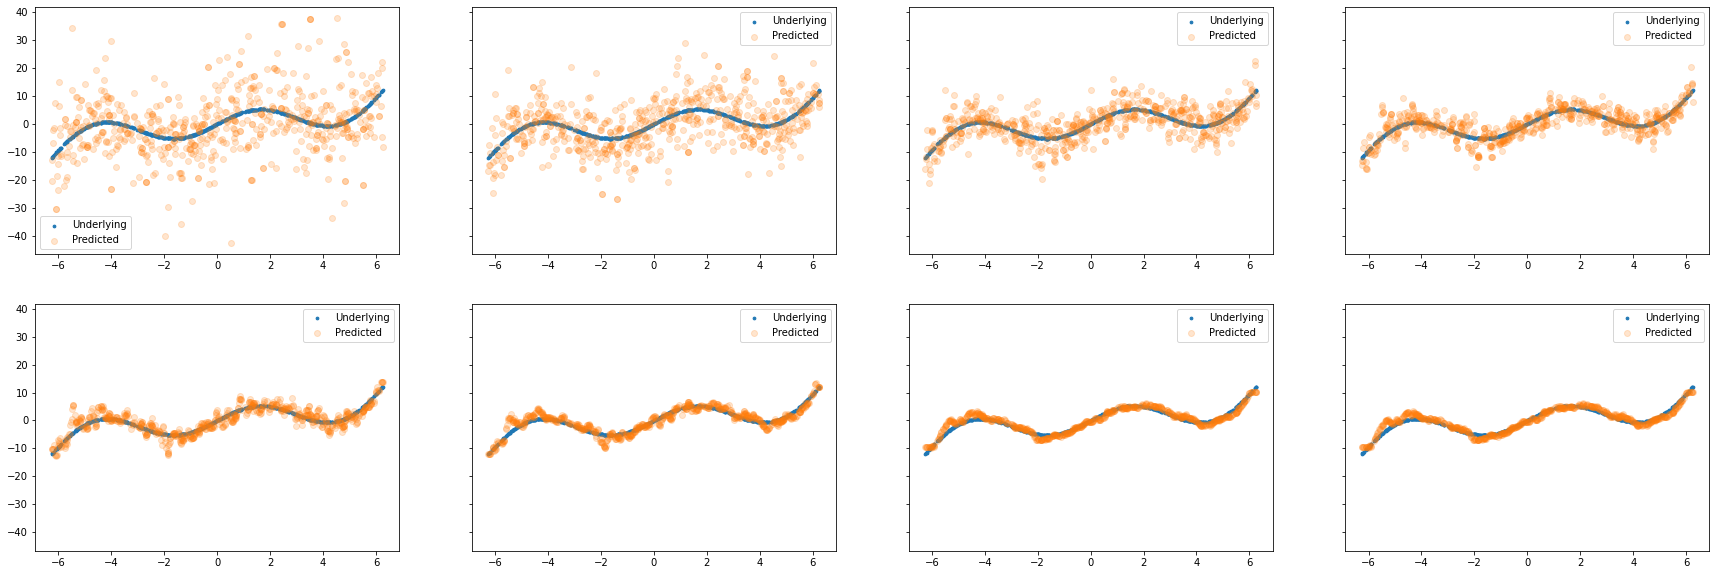

In [7]:
from sklearn.neighbors import KNeighborsRegressor as knr

fig, axes = plt.subplots(2, 4, sharey='all')
# THIRD element is the default value
n_neighbors = [1, 2, 5, 10, 20, 40, 80]

ax_len = axes.shape[0] * axes.shape[1]
for i in range(ax_len-1):
    regr = knr(n_neighbors=n_neighbors[i]).fit(x_train.reshape(-1, 1), y_train)
    y_pred = regr.predict(x_test.reshape(-1, 1))
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].legend()
    
parameters = {
    'n_neighbors':[1, 2, 5, 10, 20, 40, 80],
    'leaf_size': [10, 20, 30, 40, 50],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
regr = GridSearchCV(estimator=knr(), param_grid=parameters, n_jobs=32)
regr.fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
axes[axes.shape[0]-1][axes.shape[1]-1].legend()
plt.show()

# 2. Neural network
Its performance is much better than I thought.

/home/kongal/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kongal/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


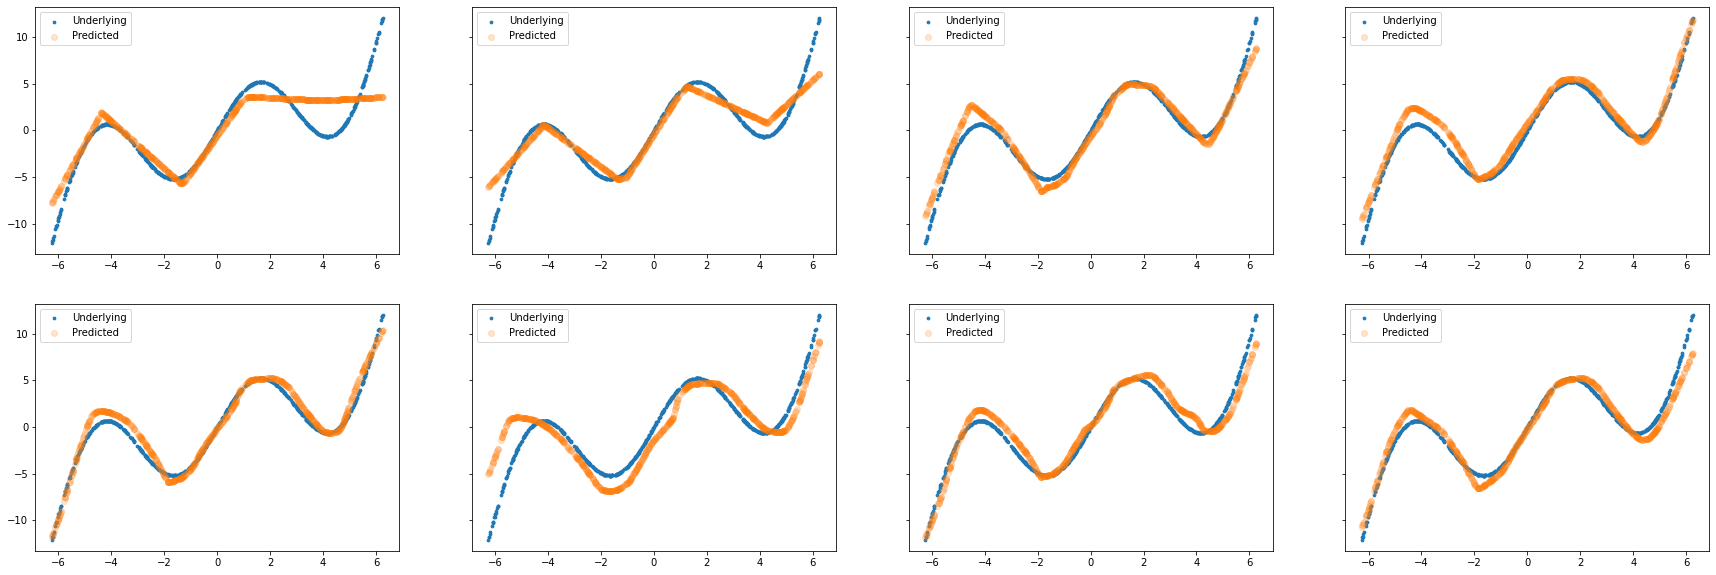

In [8]:
from sklearn.neural_network import MLPRegressor as mlp


fig, axes = plt.subplots(2, 4, sharey='all')
# SECOND combination is default values
hidden_layer_sizes = [(50, ), (100, ), (150, 150), (200, 200, 200), (250, 250, 250, 250), (300, 300, 300, 300, 300), (350, 350, 350, 350, 350, 350)]
alpha = [0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001, 0.0000005, 0.0000001]
# Here we actually are making the model more and more flexible--the default parameter set turns out to have pretty low variance--too low already!

ax_len = axes.shape[0] * axes.shape[1]
for i in range(ax_len-1):
    regr = mlp(random_state=1, hidden_layer_sizes=hidden_layer_sizes[i], tol=1e-3, max_iter=1000).fit(x_train.reshape(-1, 1), y_train)
    y_pred = regr.predict(x_test.reshape(-1, 1))
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
    axes[int(i / axes.shape[1])][i % axes.shape[1]].legend()
    
parameters = {
    'hidden_layer_sizes':[(50, ), (100, ), (200, 200), (300, 300, 300), (400, 400, 400, 400), (500, 500, 500, 500, 500), (600, 600, 600, 600, 600, 600)],
    'alpha': [1e-3, 1e-4,  1e-5, 1e-6],
    'max_iter': [2000], # 1000 always failed to converge...
    'tol': [1e-3, 1e-4, 1e-5]
}
regr = GridSearchCV(estimator=mlp(), param_grid=parameters, n_jobs=1)
regr.fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying')
axes[axes.shape[0]-1][axes.shape[1]-1].scatter(x_test, y_pred, marker='o', alpha=0.2, label='Predicted')
axes[axes.shape[0]-1][axes.shape[1]-1].legend()
plt.show()